In [1]:
%load_ext autoreload

In [99]:
%autoreload 2
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
import sys
import time
from tqdm.auto import tqdm

sys.path.append("../../..")
from plot import plot_multipopulation
from utils import get_data_class, get_result_path, load

In [8]:
## propofolPuffTone
# session = 'Mary-Anesthesia-20160809-01'
session = 'MrJones-Anesthesia-20160105-01'
# session = 'Mary-Anesthesia-20160916-02'
# session = 'MrJones-Anesthesia-20160301-01'
# session = 'MrJones-Anesthesia-20160113-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## Load Neural Data

In [83]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [84]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
T = len(lfp_schema['index'][0])
N = len(lfp_schema['index'][1])
dt = lfp_schema['smpInterval'][0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 227.13 seconds)


# Test Prediction

In [86]:
results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"

In [184]:
bandpass_info = {'flag': False}

In [185]:
windows = []
if bandpass_info is None:
    regex = re.compile(f"VAR_{session}_window_" + ".{1,3}_stride_.{1,3}_[a-zA-Z]{3}-")
else:
    if bandpass_info['flag']:
        regex = re.compile(f"VAR_{session}_window_" + ".{1,3}_stride_.{1,3}_bandpass")
    else:
        regex = re.compile(f"VAR_{session}_window_" + ".{1,3}_stride_.{1,3}_[a-zA-Z]{3}-")

for file_name in os.listdir(results_dir):
    if regex.match(file_name):
        if bandpass_info is None:
            windows.append(float(file_name.split('_')[-3]))
        else:
            if bandpass_info['flag']:
                windows.append(float(file_name.split('_')[-7]))
            else:
                windows.append(float(file_name.split('_')[-3]))
windows.sort()
windows = [int(w) if w % 1 == 0 else w for w in np.unique(windows)]

In [186]:
T_pred = 10

In [187]:
predictions = {}
true_vals = {}
step_mse = {}
for area in np.unique(electrode_info['area']):
    predictions[area] = {}
    true_vals[area] = {}
    step_mse[area] = {}
predictions['all'] = {}
true_vals['all'] = {}
step_mse['all'] = {}

for window in windows:
    stride = window
    print(f"Now computing window = {window}")
    VAR_results_dir = get_result_path(results_dir, session, window, stride, bandpass_info=bandpass_info)
    VAR_results = {}
    for file_name in tqdm(os.listdir(VAR_results_dir)):
        try:
            VAR_results[file_name] = load(os.path.join(VAR_results_dir, file_name))
        except IsADirectoryError:
            print(f"Need to compile {os.path.join(VAR_results_dir, file_name)}")
            # compile results
            VAR_results[file_name] = compile_folder(os.path.join(VAR_results_dir, file_name))
    
    for area in VAR_results.keys():
        if area == 'all':
            unit_indices = np.arange(len(electrode_info['area']))
        else:
            unit_indices = np.where(electrode_info['area'] == area)[0]
        predictions[area][window] = np.zeros((len(VAR_results[area]), T_pred, len(unit_indices)))
        true_vals[area][window] = np.zeros(predictions[area][window].shape)

        for i in tqdm(range(predictions[area][window].shape[0])):
            row = VAR_results[area].iloc[i]
            start_step = int(stride*i/dt)
            x0 = lfp[start_step + int(window/dt) - 1, unit_indices]

            for t in range(T_pred):
                if t == 0:
                    predictions[area][window][i, t] = np.hstack([[1], x0]) @ row.A_mat_with_bias
                else:
#                     predictions[area][window][i, t] = np.hstack([[1], predictions[area][window][i, t - 1]]) @ row.A_mat_with_bias
                    predictions[area][window][i, t] = np.hstack([[1], lfp[start_step + int(window/dt) - 1 + t, unit_indices]]) @ row.A_mat_with_bias

            true_vals[area][window][i] = lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices]

        step_mse[area][window] = ((predictions[area][window] - true_vals[area][window])**2).mean(axis=2)

Now computing window = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

  0%|          | 0/24889 [00:00<?, ?it/s]

Now computing window = 1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12444 [00:00<?, ?it/s]

  0%|          | 0/12444 [00:00<?, ?it/s]

  0%|          | 0/12444 [00:00<?, ?it/s]

  0%|          | 0/12444 [00:00<?, ?it/s]

  0%|          | 0/12444 [00:00<?, ?it/s]

Now computing window = 1.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8296 [00:00<?, ?it/s]

  0%|          | 0/8296 [00:00<?, ?it/s]

  0%|          | 0/8296 [00:00<?, ?it/s]

  0%|          | 0/8296 [00:00<?, ?it/s]

  0%|          | 0/8296 [00:00<?, ?it/s]

Now computing window = 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6222 [00:00<?, ?it/s]

  0%|          | 0/6222 [00:00<?, ?it/s]

  0%|          | 0/6222 [00:00<?, ?it/s]

  0%|          | 0/6222 [00:00<?, ?it/s]

  0%|          | 0/6222 [00:00<?, ?it/s]

Now computing window = 2.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4977 [00:00<?, ?it/s]

  0%|          | 0/4977 [00:00<?, ?it/s]

  0%|          | 0/4977 [00:00<?, ?it/s]

  0%|          | 0/4977 [00:00<?, ?it/s]

  0%|          | 0/4977 [00:00<?, ?it/s]

Now computing window = 3


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/4148 [00:00<?, ?it/s]

Now computing window = 3.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3555 [00:00<?, ?it/s]

  0%|          | 0/3555 [00:00<?, ?it/s]

  0%|          | 0/3555 [00:00<?, ?it/s]

  0%|          | 0/3555 [00:00<?, ?it/s]

  0%|          | 0/3555 [00:00<?, ?it/s]

Now computing window = 4


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3111 [00:00<?, ?it/s]

  0%|          | 0/3111 [00:00<?, ?it/s]

  0%|          | 0/3111 [00:00<?, ?it/s]

  0%|          | 0/3111 [00:00<?, ?it/s]

  0%|          | 0/3111 [00:00<?, ?it/s]

Now computing window = 4.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

Now computing window = 5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2488 [00:00<?, ?it/s]

  0%|          | 0/2488 [00:00<?, ?it/s]

  0%|          | 0/2488 [00:00<?, ?it/s]

  0%|          | 0/2488 [00:00<?, ?it/s]

  0%|          | 0/2488 [00:00<?, ?it/s]

Now computing window = 5.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2262 [00:00<?, ?it/s]

  0%|          | 0/2262 [00:00<?, ?it/s]

  0%|          | 0/2262 [00:00<?, ?it/s]

  0%|          | 0/2262 [00:00<?, ?it/s]

  0%|          | 0/2262 [00:00<?, ?it/s]

Now computing window = 6


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

  0%|          | 0/2074 [00:00<?, ?it/s]

Now computing window = 6.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

  0%|          | 0/1914 [00:00<?, ?it/s]

Now computing window = 7


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

Now computing window = 7.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1659 [00:00<?, ?it/s]

  0%|          | 0/1659 [00:00<?, ?it/s]

  0%|          | 0/1659 [00:00<?, ?it/s]

  0%|          | 0/1659 [00:00<?, ?it/s]

  0%|          | 0/1659 [00:00<?, ?it/s]

Now computing window = 8


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1555 [00:00<?, ?it/s]

  0%|          | 0/1555 [00:00<?, ?it/s]

  0%|          | 0/1555 [00:00<?, ?it/s]

  0%|          | 0/1555 [00:00<?, ?it/s]

  0%|          | 0/1555 [00:00<?, ?it/s]

Now computing window = 8.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1464 [00:00<?, ?it/s]

  0%|          | 0/1464 [00:00<?, ?it/s]

  0%|          | 0/1464 [00:00<?, ?it/s]

  0%|          | 0/1464 [00:00<?, ?it/s]

  0%|          | 0/1464 [00:00<?, ?it/s]

Now computing window = 9


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1382 [00:00<?, ?it/s]

  0%|          | 0/1382 [00:00<?, ?it/s]

  0%|          | 0/1382 [00:00<?, ?it/s]

  0%|          | 0/1382 [00:00<?, ?it/s]

  0%|          | 0/1382 [00:00<?, ?it/s]

Now computing window = 9.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

Now computing window = 10


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1244 [00:00<?, ?it/s]

  0%|          | 0/1244 [00:00<?, ?it/s]

  0%|          | 0/1244 [00:00<?, ?it/s]

  0%|          | 0/1244 [00:00<?, ?it/s]

  0%|          | 0/1244 [00:00<?, ?it/s]

In [162]:
# predictions_orig = predictions.copy()
# true_vals_orig = true_vals.copy()
# step_mse_orig = step_mse.copy()

# Plot

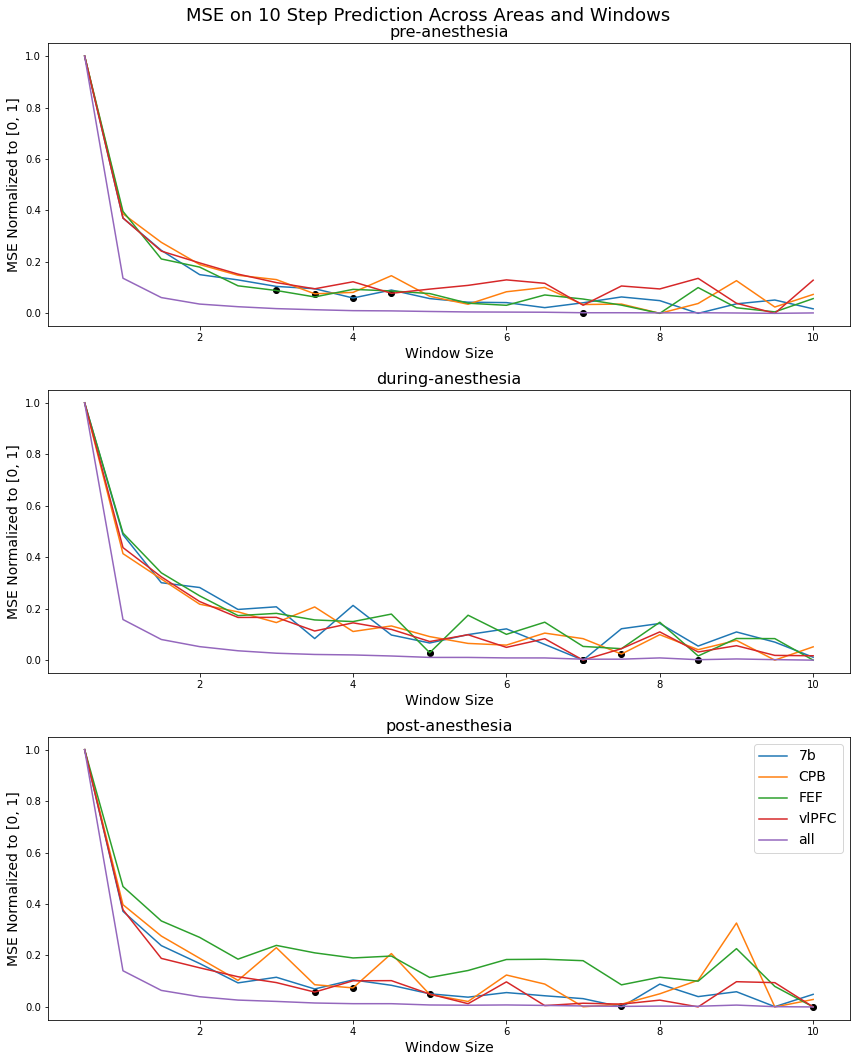

In [188]:
start_time = 120
pre_anesthesia_slice = lambda window: slice(int(start_time/window), int(session_info['drugStart'][0]/window))
during_anesthesia_slice = lambda window: slice(int(session_info['drugStart'][0]/window), int(session_info['drugEnd'][1]/window))
end_anesthesia_slice = lambda window: slice(int(session_info['drugEnd'][1]/window),-1)

rows = 3
cols = 1
fig, axs = plt.subplots(rows, cols, figsize=(12, 15))

step_to_use = 10
# improvement_thresh = 0.02 # if the improvement is less than the threshold, pick the previous window
pct_of_value = 0.95
selected_windows = {}

phases = ['pre', 'during', 'post']

for num, slice_func in enumerate([pre_anesthesia_slice, during_anesthesia_slice, end_anesthesia_slice]):
    phase = phases[num]
    selected_windows[phase] = {}
    for area in step_mse.keys():
        window_mses = [step_mse[area][window][slice_func(window), step_to_use - 1].mean() for window in windows]

        asymptotic_value = np.array(window_mses).min()
        for i in range(len(window_mses)):
            if window_mses[i]*pct_of_value <= asymptotic_value:
                selected_windows[phase][area] = windows[i]
                break

    if rows == 1 or cols == 1:
        ax = axs[num]
    for i, area in enumerate(step_mse.keys()):
    #     ax = axs[int(i/2), i % 2]
        mse_per_window = np.array([step_mse[area][window][slice_func(window), step_to_use - 1].mean() for window in windows])
        min_val = mse_per_window.min()
        max_val = mse_per_window.max()
        mse_per_window -= min_val
        mse_per_window /= max_val - min_val
        ax.plot(windows, mse_per_window, label=area)
        pt = step_mse[area][selected_windows[phase][area]][slice_func(selected_windows[phase][area]), step_to_use - 1].mean()
        pt -= min_val
        pt /= max_val - min_val
#         if num == 2 and area == '7b':
#             print(mse_per_window*0.95)
#             print(pt)
        ax.scatter(selected_windows[phase][area], pt, color='k')
    ax.set_title(f"{phase}-anesthesia", fontsize=16)
    ax.set_xlabel("Window Size", fontsize=14)
    ax.set_ylabel("MSE Normalized to [0, 1]", fontsize=14)
plt.legend(fontsize=14)
plt.suptitle(f"MSE on {step_to_use} Step Prediction Across Areas and Windows", fontsize=18)

        #     PLOT THE AREA WINDOW SIZE MSES AND A DOT AT THE SELECTED VALUE
plt.tight_layout()
plt.show()

In [183]:
selected_windows

{'pre': {'7b': 4, 'CPB': 3.5, 'FEF': 3, 'vlPFC': 4.5, 'all': 7},
 'during': {'7b': 7, 'CPB': 7.5, 'FEF': 5, 'vlPFC': 7, 'all': 8.5},
 'post': {'7b': 5, 'CPB': 4, 'FEF': 10, 'vlPFC': 3.5, 'all': 7.5}}

In [166]:
area = 'all'
window = 10

In [167]:
VAR_results = {}
result_path = get_result_path(results_dir, session, window)
for _area in tqdm(os.listdir(result_path)):
    VAR_results[_area] = load(os.path.join(result_path, _area))

  0%|          | 0/5 [00:00<?, ?it/s]

In [168]:
# plot_multipopulation(session, data_class, VAR_results, session_info, electrode_info)

In [175]:
window = 0.5

In [176]:
time_in_session = 109.5
window_num = int(time_in_session/window)

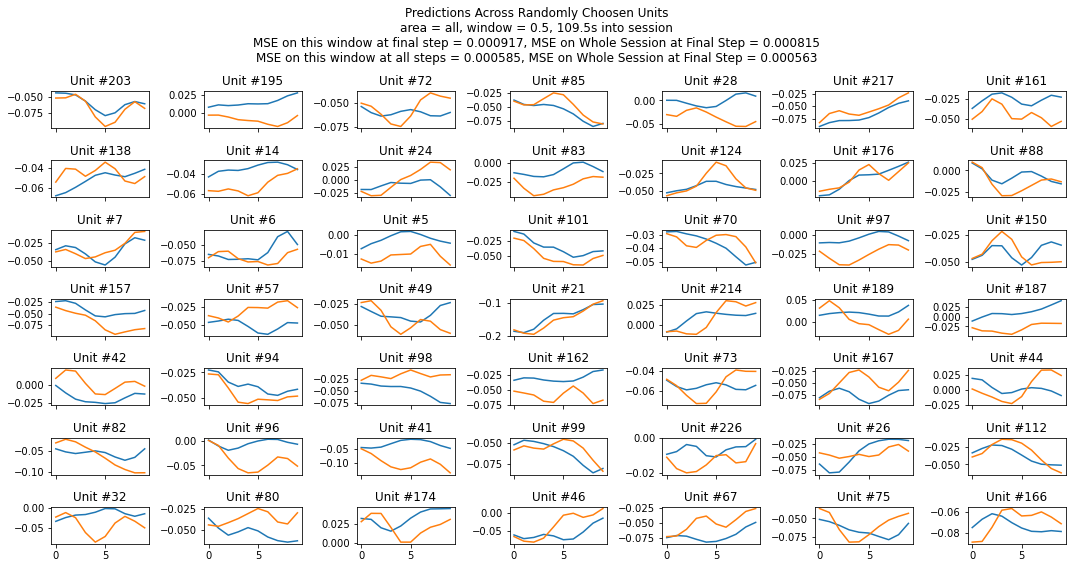

In [177]:
rows = 7
cols = 7
fig, axs = plt.subplots(rows, cols, figsize=(15, 8), sharex=True)
# unit_nums = np.random.choice(predictions[area][window].shape[2], size=(rows*cols,), replace=False)
for i, unit_num in enumerate(unit_nums):
    ax = axs[int(i/rows)][i%rows]
    ax.plot(true_vals[area][window][window_num, :, unit_num], label='true_vals')
    ax.plot(predictions[area][window][window_num, :, unit_num], label='predictions')
    ax.set_title(f'Unit #{unit_num}')
plt.suptitle(f"Predictions Across Randomly Choosen Units\narea = {area}, window = {window}, {int(time_in_session/window)*window}s into session\nMSE on this window at final step = {step_mse[area][window][window_num, -1]:.6f}, MSE on Whole Session at Final Step = {step_mse[area][window][:, -1].mean():.6f}\nMSE on this window at all steps = {step_mse[area][window][window_num, :].mean():.6f}, MSE on Whole Session at Final Step = {step_mse[area][window][:, :].mean():.6f}")
plt.tight_layout()
plt.show()

# Check For Empty Directories

In [74]:
parent_dir = '/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR'
for directory in tqdm(os.listdir(parent_dir)):
    if len(os.listdir(os.path.join(parent_dir, directory))) == 0:
        print(f"{directory} empty")
    elif '7b' in os.listdir(os.path.join(parent_dir, directory)):
        if os.path.isdir(os.path.join(parent_dir, directory, '7b')):
            print(f"{directory} not compiled")

  0%|          | 0/444 [00:00<?, ?it/s]